# Analyzing NSW Public Transports Usage - Opal Cards' Tap-ons and Tap-offs

## Problem Tasks: 

`Opal card` is the transport card which is used to tap on when entering the station, and to tap off when exit from the station in destination. The analysis of the card usage will include: 
- Examine the Opal usage data from Transport NSW and identify the patterns of different transport modes including bus, rail and ferry. 
- Having collected data about average income and age range of NSW people, we apply a suitable analysis technique in order to decide if there is a relationship between transport usage and a specific factor.

## Import Libraries

In [38]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# Plot
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

# Functions used for linear regression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics

# Functions used for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Functions used for K-Nearest Neighbours Classifier
from sklearn.neighbors import KNeighborsClassifier

# Functions used for Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Functions used for Neural Network
from sklearn.neural_network import MLPClassifier

# Functions used for Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

## Import Data

Now we import the data file and load it into a dataframe. 

In [39]:
# Import data and convert into the dataframe
df_taps = pd.read_excel("data/Mac Park vs the rest of Syd.xlsx", index_col = 0, engine="openpyxl")
df_taps.head(5)

,Suburbs,Tap-ons,Tap-offs
Dates,,,
30/8/2021,Macquarie Park,3700,3300
30/8/2021,Parramatta,9700,9200
30/8/2021,Strathfield,1900,1400
30/8/2021,Chatswood,5000,4900
31/8/2021,Macquarie Park,3700,3100


## Data Description 

The dataset obtained from [Transport NSW page](https://www.transport.nsw.gov.au/data-and-research/travel-insights?fbclid=IwAR1Bx6GzgoeFsDrZw9JYehj_ARCbovy1VZHGvJ61T00RExMrGxqUh7_LUi4)  is about the tap-on and tap-off rates of Opal cards which record the number of passengers who take the public transports daily (_these satistical data includes passengers of all modes of transports_). 
 
4 suburbs in Greater Sydney, NSW, Australia filter for the dataset include Macquarie Parks, Strathfield, Parramatta and Chatswood via the `Mac Park vs the rest of Syd.xlsx` data file. The dataset contains records of tap-on events and tap-off events of the four suburbs from 30 August 2021 to 19 September 2021.

**Steps:**
- **Data manipulation**: grouping data based on the distance of two nearby suburbs.
- **Data exploration**: plotting graphs to check the correlation of tap-ons and tap-offs between 2 suburbs. 
- **Model building**: building a Linear Regression model to _predict the number of tap-on events_ at one suburb _based on the tap-off events_ at the nearby suburb.

**Goals:**

Helping passenger plan ahead based on the traveling trends under the Covid-19 circumstance, especially in the key commercial centres such as Parramatta and Chatswood where high volume of transport uses are witnessed.

## Data Summary

In [40]:
# Examine the dataset dimension
print("# of rows:",df_taps.shape[0])
print("# of columns:",df_taps.shape[1])

# of rows: 84
# of columns: 3


In [41]:
# Statistical check of tap-on and tap-off rates
df_taps.describe()

,Tap-ons,Tap-offs
count,84.000000,84.000000
mean,4647.619048,4303.571429
std,2947.348254,2909.247674
min,900.000000,300.000000
25%,2000.000000,1700.000000
50%,3950.000000,3600.000000
75%,5700.000000,5500.000000
max,11000.000000,10500.000000


In [42]:
# Number of taps in each suburb
df_taps['Suburbs'].value_counts()

Suburbs
Macquarie Park    21
Parramatta        21
Strathfield       21
Chatswood         21
Name: count, dtype: int64

We separate the records for each distinct suburb.

In [43]:
# Group the dataframe based on Suburbs
mac_taps = df_taps[df_taps.Suburbs == "Macquarie Park"]
chat_taps = df_taps[df_taps.Suburbs == "Chatswood"]
strat_taps = df_taps[df_taps.Suburbs == "Strathfield"]
parra_taps = df_taps[df_taps.Suburbs == "Parramatta"]

In [44]:
# Statistical check of tap-on and tap-off rates for each suburb
summary_stats = pd.concat(
    {
        "Macquarie Park": mac_taps.describe(),
        "Chatswood": chat_taps.describe(),
        "Strathfield": strat_taps.describe(),
        "Parramatta": parra_taps.describe(),
    },
    axis=1
)

# Print the consolidated summary
print(summary_stats)

      Macquarie Park                 Chatswood               Strathfield  \
             Tap-ons     Tap-offs      Tap-ons     Tap-offs      Tap-ons   
count      21.000000    21.000000    21.000000    21.000000    21.000000   
mean     3342.857143  3085.714286  4800.000000  4609.523810  1723.809524   
std       889.140837   895.704033  1196.244122  1135.739742   418.216166   
min      1500.000000   900.000000  1900.000000  1900.000000   900.000000   
25%      2600.000000  2500.000000  4100.000000  4000.000000  1300.000000   
50%      3800.000000  3500.000000  5300.000000  5100.000000  2000.000000   
75%      3900.000000  3600.000000  5700.000000  5400.000000  2000.000000   
max      4200.000000  4100.000000  5900.000000  5600.000000  2100.000000   

                      Parramatta                
          Tap-offs       Tap-ons      Tap-offs  
count    21.000000     21.000000     21.000000  
mean   1266.666667   8723.809524   8252.380952  
std     468.330368   2328.068891   2258.455

* **_Interpretation:_**

Parramatta was the busiest stop (of all transport modes) recorded in the period of 30 August and 19 September in 2021. The average tap-ons and tap-offs of Opal Card (number of passengers) were up to roughly 8724 and 8252 respectively. 

The least busy transport stop was in Strathfield, where the average tap-on rate was nearly 1724 and the average tap-off rate was 1267.

## Group Data of nearby Suburbs:

* **_Methodology:_**

Two nearby suburbs are more likely to directly impact the tap-on and tap-off rates based on daily travels. Therefore, grouping data is necessary for building regression models. In this case, we group: 
- Macquarie Park and Chatswood (both have Metro service). 
- Parramatta and Strathfield (both located on the West side of Sydney). 

*_NOTE:_* we will not include the column "Suburbs" in our grouped datasets, since we only include either tap-ons or tap-offs of a suburb when grouping. For example, if we only include the tap-ons in Macquarie Park, then we group with the Tap-offs of Chatswood (include "Suburbs" column). This leads to the confusion that whether the "Tap-ons" column is referred to Chatswood or Macquarie Park. Therefore, we only **include "Tap-ons" of one suburb** and **"Tap-offs" of the other suburb**, then change the column names as their suburbs (e.g. _"Tap-ons"_ to _"Tap-ons (Mac Park)"_).

**First Group:** Macquarie Park and Chatswood

* _Tap-ons of Macquarie Park and Tap-offs of Chatswood_

In [45]:
# A temporary df to drop the unrelated columns
temp_mac_taps = mac_taps.drop(columns=['Suburbs', 'Tap-offs'])

# Add tap-offs of Chatswood and rename columns
mac_chat_taps = temp_mac_taps.rename(columns = {'Tap-ons':'Tap-ons (Mac Park)'})
mac_chat_taps['Tap-offs (Chatswood)'] = chat_taps['Tap-offs']
mac_chat_taps.head()

,Tap-ons (Mac Park),Tap-offs (Chatswood)
Dates,,
30/8/2021,3700,4900
31/8/2021,3700,4800
1/9/2021,3700,5400
2/9/2021,3900,5200
3/9/2021,4000,5100


* _Tap-ons of Chatswood and Tap-offs of Macquarie Park_

In [51]:
# A temporary df to drop the unrelated columns
temp_chat_taps = chat_taps.drop(columns=['Suburbs', 'Tap-offs'])

# Add tap-offs of Macquarie Park and rename columns
chat_mac_taps = temp_chat_taps.rename(columns = {'Tap-ons':'Tap-ons (Chatswood)'})
chat_mac_taps['Tap-offs (Mac Park)'] = mac_taps['Tap-offs']
chat_mac_taps.head(3)

,Tap-ons (Chatswood),Tap-offs (Mac Park)
Dates,,
30/8/2021,5000,3300
31/8/2021,5200,3100
1/9/2021,5200,3500


**Second Group:** We group Strathfield and Parramatta

* _Tap-ons of Strathfield and Tap-offs of Parramatta_

In [52]:
# create a temporary dataframe that drops the unrelated columns
temp_strat_taps = strat_taps.drop(columns=['Suburbs', 'Tap-offs'])

# Add a tap-offs of Chatswood and rename the columns to clearly state which column belongs to which suburb
strat_parra_taps = temp_strat_taps.rename(columns = {'Tap-ons':'Tap-ons (Strathfield)'})
strat_parra_taps['Tap-offs (Parramatta)'] = parra_taps['Tap-offs']
strat_parra_taps.head(3)

,Tap-ons (Strathfield),Tap-offs (Parramatta)
Dates,,
30/8/2021,1900,9200
31/8/2021,1800,9100
1/9/2021,2000,9200


* _Tap-ons of Parramatta and Tap-offs of Strathfield_

In [53]:
# create a temporary dataframe that drops the unrelated columns
temp_parra_taps = parra_taps.drop(columns=['Suburbs', 'Tap-offs'])

# Add a tap-offs of Macquarie Park and rename the columns to clearly state which column belongs to which suburb
parra_strat_taps = temp_parra_taps.rename(columns = {'Tap-ons':'Tap-ons (Parramatta)'})
parra_strat_taps['Tap-offs (Strathfield)'] = strat_taps['Tap-offs']
parra_strat_taps.head(3)

,Tap-ons (Parramatta),Tap-offs (Strathfield)
Dates,,
30/8/2021,9700,1400
31/8/2021,9400,1300
1/9/2021,9800,1600


## Data Exploration

### Correlation check

Seaborn-based regression plots to examine if the tap-on events of one suburb are correlated with the tap-off events at the other suburb:

**First Group (Macquarie Park v.s Chatswood):**

[(500.0, 6500.0)]

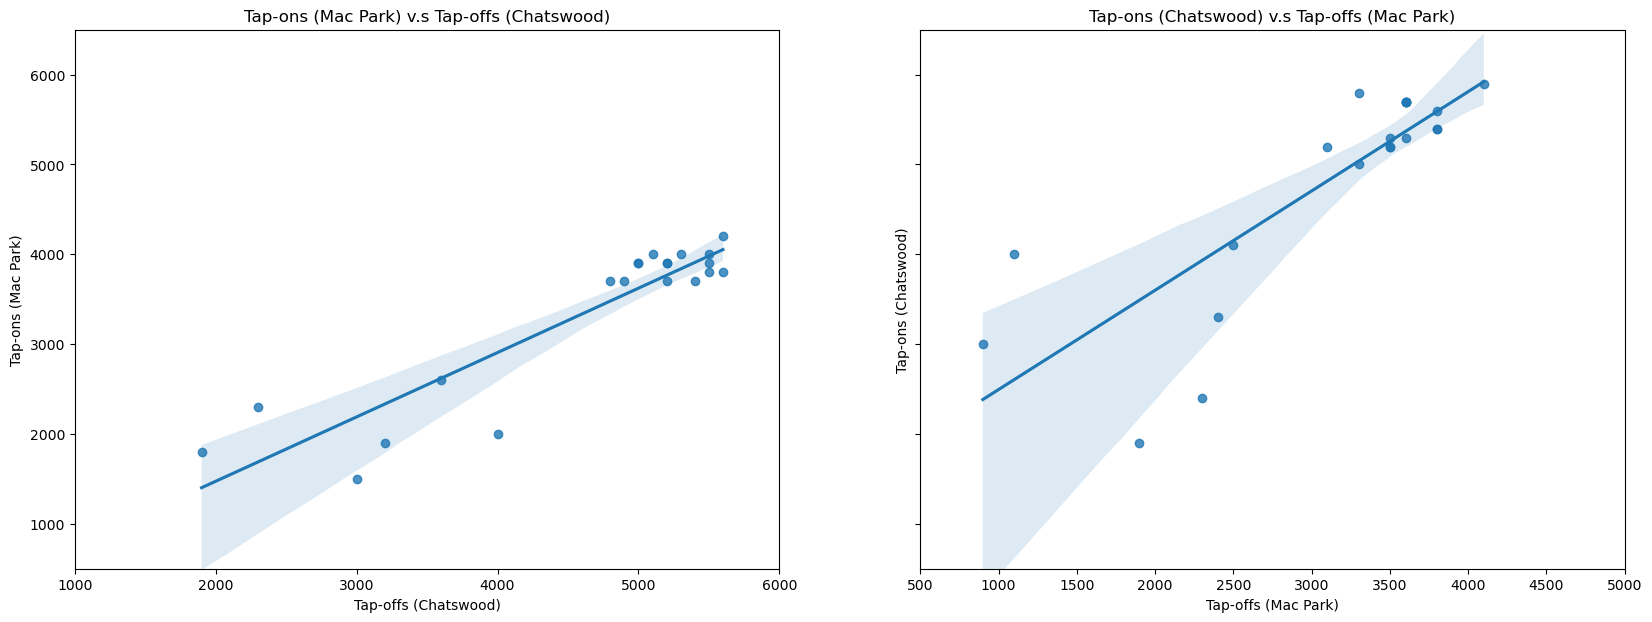

In [55]:
# Subplots setting
fig, axes = plt.subplots(figsize = (20,7), ncols=2, sharey= True)

# Tap-ons (Mac Park) v.s Tap-offs (Chatswood) Correlation
chat_mac_plot = sns.regplot(x= "Tap-offs (Chatswood)", y= "Tap-ons (Mac Park)", data= mac_chat_taps, ax=axes[0])
chat_mac_plot.set_title("Tap-ons (Mac Park) v.s Tap-offs (Chatswood)")
chat_mac_plot.set(xlim=(1000, 6000))
chat_mac_plot.set(ylim=(500, 6500))

# Tap-ons (Chatswood) v.s Tap-offs (Mac Park) Correlation
mac_chat_plot = sns.regplot(x= "Tap-offs (Mac Park)", y= "Tap-ons (Chatswood)", data= chat_mac_taps, ax=axes[1])
mac_chat_plot.set_title("Tap-ons (Chatswood) v.s Tap-offs (Mac Park)")
mac_chat_plot.set(xlim=(500, 5000))
mac_chat_plot.set(ylim=(500, 6500))

**Second Group (Strathfield v.s Parramatta):**

[(500.0, 12000.0)]

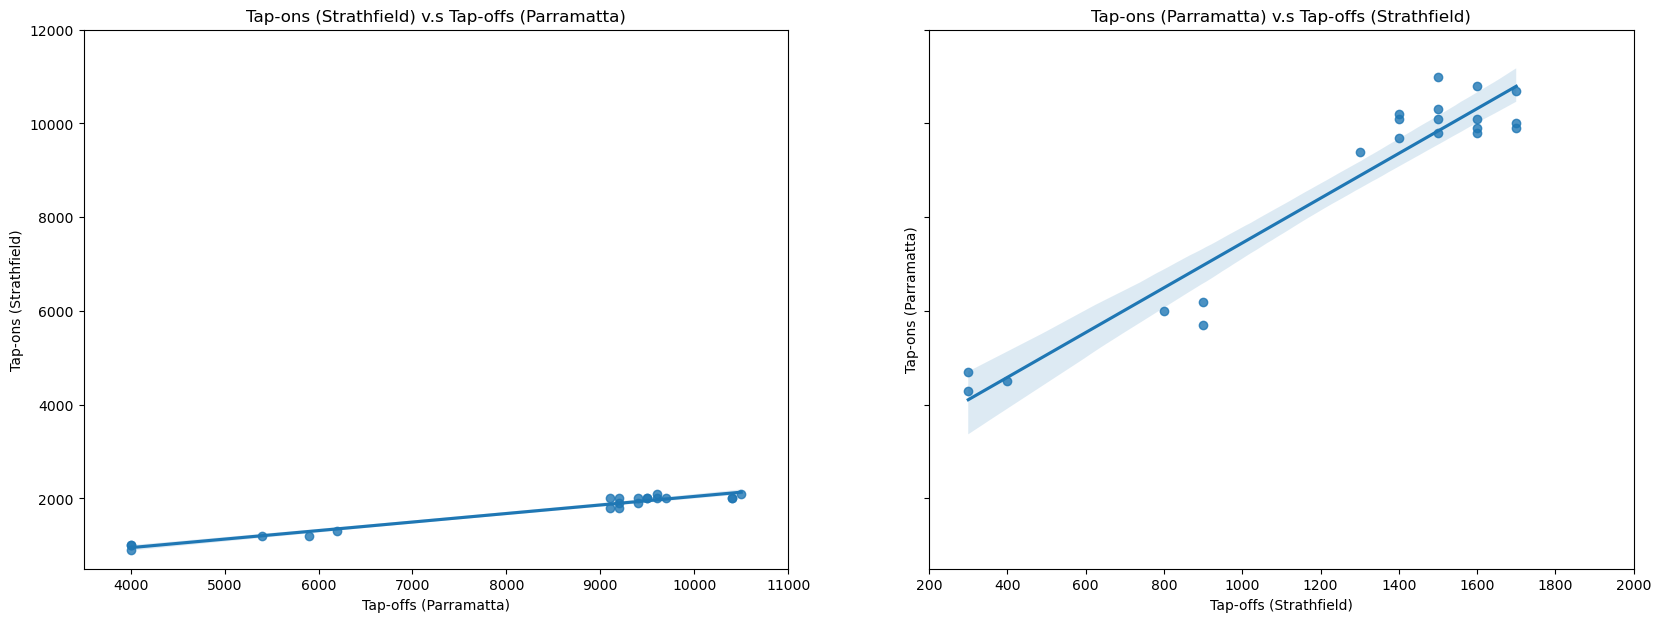

In [56]:
# Subplots setting
fig, axes = plt.subplots(figsize = (20,7), ncols=2, sharey= True)

# Tap-ons (Strathfield) v.s Tap-offs (Parramatta) Correlation
parra_strat_plot = sns.regplot(x= "Tap-offs (Parramatta)", y= "Tap-ons (Strathfield)", data= strath_parra_taps, ax=axes[0])
parra_strat_plot.set_title("Tap-ons (Strathfield) v.s Tap-offs (Parramatta)")
parra_strat_plot.set(xlim=(3500, 11000))
parra_strat_plot.set(ylim=(500, 12000))

# Tap-ons (Parramatta) v.s Tap-offs (Strathfield) Correlation
strat_parra_plot = sns.regplot(x= "Tap-offs (Strathfield)", y= "Tap-ons (Parramatta)", data= parra_strath_taps, ax=axes[1])
strat_parra_plot.set_title("Tap-ons (Parramatta) v.s Tap-offs (Strathfield)")
strat_parra_plot.set(xlim=(200, 2000))
strat_parra_plot.set(ylim=(500, 12000))

* **Interpretation**: 

From both plots of each group, the distance from each point to the regressive line is closer for the first plot. Therefore, setting up **linear regression models** for the **_first pair of each group_** is the most optimal option (e.g. Predict _tap-on events in Strathfield_ based on _tap-off events in Parramatta_).

## Model Building

We build the linear regression model for the two groups we presented previously. Let X (independent variable) be the tap-off events, and y (dependent variable) be the tap-on events.

### Model for First Group(Macquarie Park v.s. Chatswood):

We predict the tap-on events in Macquarie Park based on the Tap-off events in Chatswood.

**Create the linear model**

In [14]:
first_reg = linear_model.LinearRegression()

**Split into train and test datasets, and fit data into the model**

In [15]:
# split the dataframe into train (80%) and test (20%) with random state = 142
first_train, first_test= train_test_split(mac_chats_taps, test_size=0.2, random_state=142)
print("train size:", first_train.shape)
print("test size:", first_test.shape)

train size: (16, 2)
test size: (5, 2)


In [16]:
# fit the data in train into the regression model
first_X_train = first_train[['Tap-offs (Chatswood)']]
first_y_train = first_train['Tap-ons (Mac Park)']

first_reg.fit(first_X_train, first_y_train)

LinearRegression()

In [17]:
# assign the variables of testing dataset
first_X_test = first_test[['Tap-offs (Chatswood)']]
first_y_test = first_test['Tap-ons (Mac Park)']

**Predict tap-on events based on tap-off events**

In [18]:
# do prediction on the train set
first_train_preds = first_reg.predict(first_X_train)
print("The predicted tap-on events on train set are:", first_train_preds)

# do prediction on the test set
first_test_preds = first_reg.predict(first_X_test)
print("The predicted tap-on events on test set are:", first_test_preds)

The predicted tap-on events on train set are: [3755.58732132 3755.58732132 3978.99316346 3978.99316346 3606.65009323
 3755.58732132 3681.11870727 3606.65009323 4053.4617775  2564.08949658
 3904.52454941 4053.4617775  3830.05593536 2117.27781231 2861.96395277
 1595.99751398]
The predicted tap-on events on test set are: [3978.99316346 3457.71286513 3532.18147918 2266.2150404  1298.1230578 ]


**Evaluation**

We apply mean square error (MSE) and $R^2$ to check if the model fits well (i.e. whether the predicted tap-on events is slightly diffferent from the actual tap-on events in Macquarie Park).

In [19]:
print("\nThe test set's MSE is:",mean_squared_error(first_y_test, first_test_preds))
print("The test set's root MSE is:", np.sqrt(mean_squared_error(first_y_test, first_test_preds)))
print("The test set's R squared score is:",r2_score(first_y_test, first_test_preds))


The test set's MSE is: 94660.26395187716
The test set's root MSE is: 307.66908189136774
The test set's R squared score is: 0.8977309162144802


* **_Interpretation:_** The $R^2$ of the testing dataset is roughly 0.898, which the test dataset fits the model quite well. However, the MSE value corresponds to a prediction error of roughly 308 tap-ons at all the transport stops of Macquarie Park, which is approximately 9% of the actual mean value of the tap-off events. Therefore this model might be considered as a quite good model.

### Model for Second Group (Strathfield v.s. Parramatta):

We repeat the same steps as the first group to build the linear model. We predict the tap-on events in Strathfield based on the tap-off events in Parramatta.

**Create the linear model**

In [20]:
second_reg = linear_model.LinearRegression()

**Split into train and test datasets, and fit data into the model**

In [21]:
# split the dataframe into train (80%) and test (20%) with random state = 142
second_train, second_test= train_test_split(strath_parra_taps, test_size=0.2, random_state=142)
print("train size:", second_train.shape)
print("test size:", second_test.shape)

train size: (16, 2)
test size: (5, 2)


In [22]:
# fit the data in train into the regression model
second_X_train = second_train[['Tap-offs (Parramatta)']]
second_y_train = second_train['Tap-ons (Strathfield)']

second_reg.fit(second_X_train, second_y_train)

LinearRegression()

In [23]:
# assign the variables of testing dataset
second_X_test = second_test[['Tap-offs (Parramatta)']]
second_y_test = second_test['Tap-ons (Strathfield)']

**Predict tap-on events based on tap-off events**

In [24]:
# do prediction on the train set
second_train_preds = second_reg.predict(second_X_train)
print("The predicted tap-on events on train set are:", second_train_preds)

# do prediction on the test set
second_test_preds = second_reg.predict(second_X_test)
print("The predicted tap-on events on test set are:", second_test_preds)

The predicted tap-on events on train set are: [1948.83611266 1968.26638659 2007.12693445 1968.26638659 1987.69666052
 1948.83611266 1987.69666052 1909.9755648  1890.54529086 1327.06734685
 1909.9755648  2162.56912591 2143.13885197  899.60132036 1268.77652506
 1171.6251554 ]
The predicted tap-on events on test set are: [2143.13885197 1890.54529086 1909.9755648   899.60132036  899.60132036]


**Evaluation**

We apply mean square error (MSE) and $R^2$ to check if the model fits well (i.e. whether the predicted tap-on events is slightly diffferent from the actual tap-on events in Strathfield).

In [25]:
print("\nThe test set's MSE is:",mean_squared_error(second_y_test, second_test_preds))
print("The test set's root MSE is:", np.sqrt(mean_squared_error(second_y_test, second_test_preds)))
print("The test set's R squared score is:",r2_score(second_y_test, second_test_preds))


The test set's MSE is: 9789.29645655884
The test set's root MSE is: 98.94087353848681
The test set's R squared score is: 0.9506587880213768


* **_Interpretation:_** The $R^2$ of the testing dataset is significantly high, which is roughly 0.951. this means the test dataset fits the model well. The MSE value corresponds to a prediction error of roughly 99 tap-ons at all the transport stops of Strathfield, which is approximately 6% of the actual mean value of the tap-off events. Therefore this model might be considered as a good model.

## Conclusion

There exist **many factors** that potentially **affect the datasets**. For example: 
- Train service works in Chatswood while Macquarie Park has only bus and metro services.
- No ferry service in Strathfield while tap-offs at Parramatta include Parramatta Wharf's passengers. 

Two **linear regression models** are applied to analyse the relationship between the tap-ons at all the transport stops in one suburb and the tap-offs at all the transport stops in another suburbs. Specifically, _pairs of data_ are: 
- Tap-ons at Macquarie Park and tap-offs at Chatswood. 
- Tap-ons at Strathfield the tap-offs at Parramatta.

From the model outputs, **better model performance** is recognized _between Strathfield and Parramatta_ than Macquarie Park and Chatswood, with $R^2$ of 0.951 and 0.898 respectively. Moreover, the percentage of **RMSE** comapred to the actual mean value of the _Strathfield v.s Parramatta model_ is considerably lower than the _Macquarie Park v.s Chatswood model_ (6% v.s 9%). 

In conclusion, predictions for the **tap-on rates at Parramatta** is _more precise_ than _predictions for Macquarie Park_. With this model, we can predict the traveling trend from the two nearby suburbs and give recommendation for passengers to plan ahead, especially traveling under the Covid-19 circumstances around the key commercial cities (e.g. Parramatta).